# Spline transformations of points

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import summerschool as ss
import os

## Linear/Affine transformations have too few degrees of freedom
They cannot model spatially varying growth and atrophy.  Because they're linear, they look the same everywhere.

## Arbitrary vector fields have too many degrees of freedom

If we have an arbitrary vector field $v(x)$, and we want to match a set of points $X$ to a set of points $Y$, we can just define the vector field as
\begin{align*}
v(x) &=
\left\{
\begin{array}{ll}
Y_i-X_i, & x=X_i\\
\text{anything}, & \text{otherwise}
\end{array}
\right.
\end{align*}

Usually we want to use vector fields to find out how images are deforming at points other than directly on the labeled landmarks.  These vector fields have too many degres of freedom to be useful.  

One way to effectively reduce the degrees of freedom is by enforcing the vector fields to be smooth.  This is natural because growth and atrophy of tissue in one position tends to be quite similar to that in nearby positions.

## Energy methods for enforcing smoothness
Let's define the energy of a vector field by
\begin{align*}
E &= \frac{1}{2}\int v^T(x) A v(x) dx
\end{align*}
where $A$ is a differential operator.

For example, if $v$ represents the displacement of points in an elastic body in one dimension, then elastic energy is given by
\begin{align*}
\frac{1}{2}\int k\left|\frac{d}{dx}v(x)\right|^2dx
\end{align*}
Just like a spring has potential energy according to Hooke's law, which is quadratic in displacement ($E = \frac{1}{2} k (\Delta x)^2$) https://en.wikipedia.org/wiki/Hooke%27s_law#Spring_energy , an elastic body has energy which is quadratic in local displacment (i.e. the derivative).

We can rewrite this energy in the above form
\begin{align*}
&= \int k\frac{d}{dx}v^T(x)\frac{d}{dx}v(x) dx\\
&= \frac{1}{2}\int  v^T(x) \left( -k \frac{d^2}{dx^2}\right)v(x) dx\\
&= \frac{1}{2}\int  v^T(x)Av(x) dx\\
\end{align*}
for $A = -k \frac{d^2}{dx^2}$.  Here we used the integration by parts, assuming 0 boundary conditions.

A common choice for $A$ used in the image registration community is identity minus Laplacian times a constant raised to some integer power: $A = (id - a^2\Delta)^{2p}$ for some choice of $a$ (with units of space) and $p$ (an integer, typically 2 or 4).  

For a well defined positive energy, $A$ should be symmetric (i.e. a Hermitian operator) positive definite.

We can now pose a new landmark matching problem.

minimize $\frac{1}{2} \int v^T(x) A v(x)dx$ subject to the constraints $v(X_i) = Y_i-X_i$.  

This is a constrained optimization problem.  We could also consider an unconstrained problem, where $X_i + v(X_i)$ should be close (but not exactly equal) to $Y_i$.

minimize $\frac{1}{2} \int v^T(x) A v(x)dx + \frac{1}{2\sigma^2} \sum_i |X_i + v(X_i) - Y_i|^2$

Below we will use the first (constrained) problems.

## Green's kernels for solutions to energy problems
Write down the minimization problem with constraints using Lagrange multipliers.  We minimize the cost
\begin{align*}
C = \frac{1}{2}\int v^T(x) A v(x) dx +  \sum_i \lambda_i^T[(Y_i - X_i) - v(X_i)]
\end{align*}
where $\lambda_i$ are the Lagrange multipliers.

We look for a stationary solution by taking perturbations $v \mapsto v + \epsilon \delta v$, and insiting the change be zero for all possible choices of perturbation.  
\begin{align*}
&\frac{d}{d\epsilon}\frac{1}{2} \int (v+\epsilon \delta v)^T(x) A (v+\epsilon \delta v)(x) dx +  \sum_i \lambda_i^T[(Y_i - X_i) - v(X_i) - \epsilon \delta v(X_i)] \bigg|_{\epsilon = 0}\\
&= \int Av^T(x) \delta v(x) dx + \sum_i \lambda_i \delta v(X_i)
\end{align*}

Let's use a Dirac $\delta$ to put everything under the same integral.
\begin{align*}
&= \int Av^T(x) \delta v(x)  - \sum_i \lambda_i^T \delta v(x) \delta (x-X_i)dx\\
&=\int \left(Av(x) - \sum_i \lambda_i^T \delta(x-X_i)\right)^T \delta v(x) dx
\end{align*}
If this variation is to be 0 for any perturbation, we require
\begin{align}
Av(x) = \sum_i \lambda_i \delta(x-X_i)
\end{align}

To solve this, we need to invert the operator $A$.  We'll assume that there is a function $K(x,y)$ such that $A K(x,y) = \delta(x-y)$.  This is called the Green's function of the operator.  The Green's functions for many operators can be looked up https://en.wikipedia.org/wiki/Green%27s_function.  Sometimes a convenient way to derive Green's functions is by using Fourier transforms.  


Let's plug in the Green's function
\begin{align*}
Av(x) &= \sum_i A K(x,X_i)  \lambda_i \\
&= A\left(\sum_i  K(x,X_i) \lambda_i\right)
\end{align*}
Since $A$ is positive definite, this will be true if
\begin{align*}
v(x) &= \sum_i  K(x,X_i)\lambda_i
\end{align*}

This gives us the FORM of the solution.  Now we have to find the values of the Lagrange multipliers that will satisfy the constraints.  We require
\begin{align*}
v(X_j) &= \sum_i  K(X_j,X_i) \lambda_i\\
&= Y_j-X_j
\end{align*}
This is just a linear equation, it can be written in matrix form.  We will write $X$ as a $3xN$ matrix, where the $i$th column is $X_i$, and similarly for $Y$ and $\lambda$.
\begin{align*}
\lambda \bar K = Y-X \implies \lambda = (Y-X)\bar K^{-1}
\end{align*}
where $\bar K$ is the $NxN$ matrix whose $i$th row and $j$th column is $K(X_i,X_j)$.

Note that the solution to the problem can be written in terms of $K$ only, not $A$.  

In many cases we'll simply choose a Green's kernel, rather than an energy operator.

<IPython.core.display.Javascript object>


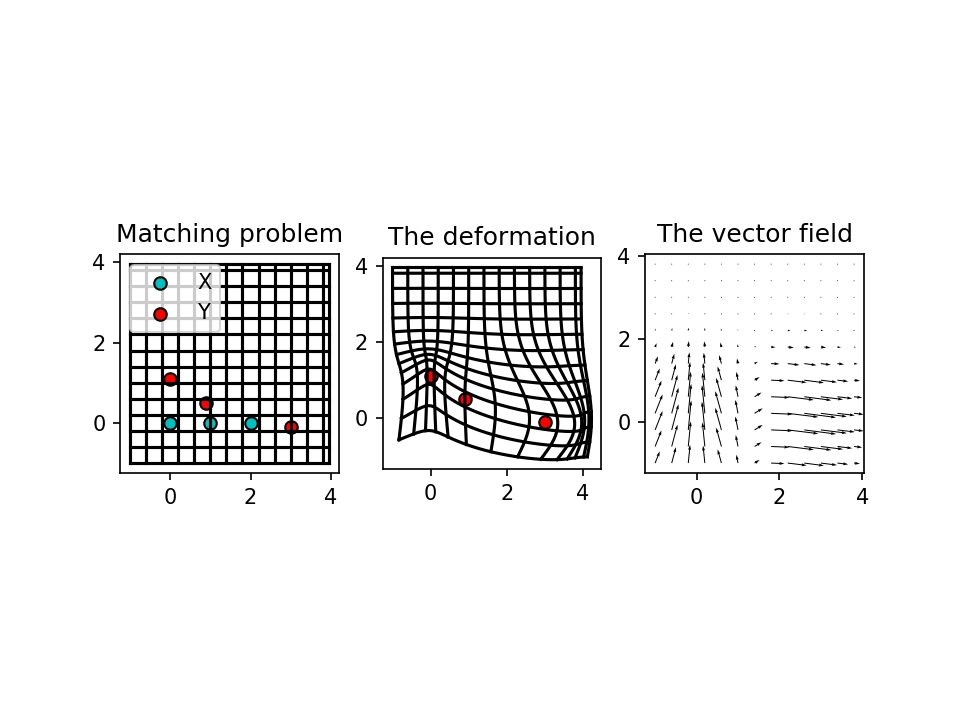

K matrix is 
[[1.         0.60653066 0.13533528]
 [0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]


Text(0.5,1,'The vector field')

In [2]:
# let's solve an example problem
f,ax = plt.subplots(1,3)
# simple example landmarks, match X to Y
X = np.array([[0,0],[1,0],[2,0]]).transpose()
Y = np.array([[0,1.1],[0.9,0.5],[3,-0.1]]).transpose()
n = X.shape[1]

# use a Gaussian kernel because it is "nice" (simple, smooth, separable, rotationally symmetric, etc.) 
# we will define the kernel instead of defining the operator
# either choice is valid
k = lambda x, y: np.exp(-np.sum((x-y)**2)/(2.0*1.0**2))

# make a picture
dx = 0.05
stride = 8
x0 = np.arange(-1,4,dx)
x1 = np.arange(-1,4,dx)
X0,X1 = np.meshgrid(x0,x1,indexing='ij')
ss.plot_grid(X0,X1,ax=ax[0],rstride=stride,cstride=stride)
hx = ax[0].scatter(X[0,:],X[1,:],color='c',edgecolor='k')
hy = ax[0].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[0].set_aspect('equal')
ax[0].legend([hx,hy],['X','Y'])
ax[0].set_title('Matching problem')

# define a kernel matrix K
K = np.empty((n,n))
for i in range(n):
    for j in range(n):
        K[i,j] = k(X[:,i],X[:,j])
print('K matrix is \n{}'.format(K))

# solve the linear system
Lambda = np.linalg.solve(K,(Y-X).transpose()).transpose()

# we would like to see the smooth displacment field v(x)
# this defines a function v(x) = sum_i lambda_i k(x_i,x)
# let's use it to deform the grid for visualization
phiX0 = np.array(X0)
phiX1 = np.array(X1)
for i in range(len(x0)):
    for j in range(len(x1)):
        # this point
        p = np.array([X0[i,j],X1[i,j]])
        for k_ in range(n):
            phiX0[i,j] += Lambda[0,k_]*k(p,X[:,k_])
            phiX1[i,j] += Lambda[1,k_]*k(p,X[:,k_])
ss.plot_grid(phiX0,phiX1,ax=ax[1],rstride=stride,cstride=stride)
# the deformed landmarks X + v(X) should be exactly equal to Y, so we only plot one of them
hy = ax[1].scatter(Y[0,:],Y[1,:],color='r',edgecolor='k')
ax[1].set_aspect('equal')
ax[1].set_title('The deformation')

ax[2].quiver(X0[::stride,::stride],X1[::stride,::stride],phiX0[::stride,::stride]-X0[::stride,::stride],
             phiX1[::stride,::stride]-X1[::stride,::stride],
             scale=stride)
ax[2].set_aspect('equal')
ax[2].set_title('The vector field')

In [ ]:
# now our 3D data
# daniel update
#fname = os.path.join('hipAmygLandmarks', 'hippocampus_01_landmarks.txt')
fname = os.path.join('mouse_hippo_landmarks', 'hippocampus_01_landmarks.txt')
X = ss.load_landmarks(fname)
#fname = os.path.join('hipAmygLandmarks', 'hippocampus_01_surface.byu')
fname = os.path.join('mouse_hippo_landmarks', 'hippocampus_01_surface.byu')
V0,F0 = ss.load_surface(fname)

# get a landmarks
#fname = os.path.join('hipAmygLandmarks', 'hippocampus_02_landmarks.txt')
fname = os.path.join('mouse_hippo_landmarks', 'hippocampus_02_landmarks.txt')
Y = ss.load_landmarks(fname)
#fname = os.path.join('hipAmygLandmarks', 'hippocampus_02_surface.byu')
fname = os.path.join('mouse_hippo_landmarks', 'hippocampus_02_surface.byu')
V1,F1 = ss.load_surface(fname)

n = X.shape[1]

# define a kernel matrix
k = lambda x, y: np.exp(-np.sum((x-y)**2)/(2.0*2.0**2))
K = np.empty((n,n))
for i in range(n):
    for j in range(n):
        K[i,j] = k(X[:,i],X[:,j])
print('K matrix is size {}x{}'.format(K.shape[0],K.shape[1]))
Lambda = np.linalg.solve(K,(Y-X).transpose()).transpose()

# calculate the deformed vertices of our triangulated surface
# these vertices are deformed smoothly based on the landmarks that they are close to
# so we expect the deformed template surface to look similar to the target surface
phiV0 = np.array(V0)
for i in range(V0.shape[1]):
    # this point    
    for k_ in range(n):
        phiV0[:,i] += Lambda[:,k_]*k(V0[:,i],X[:,k_])
# plot our results
f = plt.figure()
ax = f.add_subplot(1,2,1,projection='3d')
ax.plot_trisurf(V0[0,:],V0[1,:],V0[2,:],triangles=F0,color='c',alpha=0.5)
hx = ax.scatter(X[0,:],X[1,:],X[2,:],color='c',edgecolor='k')
ax.plot_trisurf(V1[0,:],V1[1,:],V1[2,:],triangles=F1,color='r',alpha=0.5)
hy = ax.scatter(Y[0,:],Y[1,:],Y[2,:],color='r',edgecolor='k')
ax.legend([hx,hy],['X','Y'],loc=6)
ss.axis_equal(ax)
ax.set_title('X and Y points \nwith corresponding surfaces')

ax = f.add_subplot(1,2,2,projection='3d')
ax.plot_trisurf(V0[0,:],V0[1,:],V0[2,:],triangles=F0,color='c',alpha=0.1)
ax.plot_trisurf(phiV0[0,:],phiV0[1,:],phiV0[2,:],triangles=F0,color='b',alpha=0.5)
ax.plot_trisurf(V1[0,:],V1[1,:],V1[2,:],triangles=F1,color='r',alpha=0.5)
ss.axis_equal(ax)
ax.set_title('Deformed template surface (blue)')